In [1]:
import sys
sys.path.append("../")

In [2]:
import pickle
import random
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
from plotly.subplots import make_subplots

from simulator.simulator import Sim
from strategies.rl import (
    A2CNetwork,
    Policy,
    RLStrategy,
    A2C,
    ComputeValueTargets,
    evaluate,
)
from utils.get_info import get_pnl, get_volumes
from utils.load_data import load_md_from_csv
from datetime import datetime
from tqdm import tqdm


In [3]:
def preprocess_data(csv_books, csv_trades, num_rows=-1):
    return load_md_from_csv(csv_books, csv_trades, num_rows=num_rows)


In [4]:
def prepare_features(features_snapshot):
    # TODO: MOVE THE FEATURES NOTEBOOK HERE
    with open(features_snapshot, "rb") as f:
        features_dict = pickle.load(f)

    # TODO: DETERMINE THE RIGHT DATA TYPE OF THE RECEIVE_TS COLUMN
    features = (
        pd.DataFrame.from_dict(features_dict, orient="index")
        .reset_index()
        .rename(columns={"index": "receive_ts"})
    )
    features["inventory_ratio"] = 0.0
    features["tpnl"] = 0.0


    means_dict = features.mean(numeric_only=True).to_dict()
    means = [means_dict.get(c, 0) for c in features.columns[1:]]
    stds_dict = features.std(numeric_only=True).to_dict()
    stds = [stds_dict.get(c, 0) for c in features.columns[1:]]

    return features, np.array(means, dtype=float), np.array(stds, dtype=float)

In [5]:
def test(checkpoint, dataset, features, means, stds):
    breakpoint()
    model = A2CNetwork(n_actions=10, device=DEVICE).to(DEVICE)
    model.load_state_dict(torch.load(checkpoint))
    model.eval()

    policy = Policy(model)

    strategy = RLStrategy(
        policy,
        features,
        1.0,
        means,
        stds,
        DELAY,
        HOLD_TIME,
        [ComputeValueTargets(policy)],
        trade_size=0.01,
        post_only=True,
        taker_fee=0.0004,
        maker_fee=-0.00004,
    )

    strategy.reset()
    sim = Sim(
        dataset,
        execution_latency=LATENCY,
        datency=DATENCY,
    )
    with torch.no_grad():

        trades_list, md_list, updates_list, actions_history, trajectory = strategy.run(
            sim, mode="test"
        )

        res = {
        "PnL": strategy.realized_pnl + strategy.unrealized_pnl,
        "from": datetime.fromtimestamp(dataset[0].receive_ts).strftime("%Y-%m-%dT%H-%M-%S"),
        "to": datetime.fromtimestamp(dataset[-1].receive_ts).strftime("%Y-%m-%dT%H-%M-%S"),
        "delay": DELAY,
        "hold_time": HOLD_TIME,
        "traj_size": TRAJ_SIZE,
        "latency": LATENCY,
        "datency": DATENCY,
        "S": S,
        "SS": SS,
        }

        print(res)
        return trades_list, md_list, updates_list, actions_history, trajectory


In [6]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

N = 300 # NUM OF EPOCHS
S = 500_000 # TRAIN SIZE
SS = 50_000 # EVALU SIZE, SHOULD BE CLOSE TO traj_size
#assert SS < S / 10
TRAJ_SIZE = 5000 # N * traj_size << S 
DELAY = pd.Timedelta(0.1, "s").total_seconds()
HOLD_TIME = pd.Timedelta(10, "s").total_seconds()
LATENCY = pd.Timedelta(10, "ms").total_seconds()
DATENCY = pd.Timedelta(10, "ms").total_seconds()

In [7]:
dataset = preprocess_data(
    "../data/books.csv", "../data/trades.csv", num_rows=3 * S
)

print("TOTAL DATA UPDATES: %d" % len(dataset))


TOTAL DATA UPDATES: 1646593


In [8]:
features, means, stds = prepare_features("../data/features.pickle")

In [9]:
checkpoint = "../models/rl_PnL_18892.42363259998_S_500000_SS_50000_datency_0.01_delay_0.1_epoch_i_300_from_2023-01-09T08-00-00_hold_time_10.0_latency_0.01_num_ecphos_300_to_2023-01-13T16-21-33_traj_size_5000.pth"

In [14]:
trades_list, md_list, updates_list, actions_history, trajectory = test(checkpoint, dataset[S+SS:S+2*SS], features, means, stds)

[TEST] MODE RUN IN RANGE [2023-01-13 16:21:34, 2023-01-13 23:38:11.409000]
{'PnL': 18809.333340679925, 'from': '2023-01-13T16-21-34', 'to': '2023-01-13T23-38-11', 'delay': 0.1, 'hold_time': 10.0, 'traj_size': 5000, 'latency': 0.01, 'datency': 0.01, 'S': 500000, 'SS': 50000}


In [15]:
%%time

df = get_pnl(updates_list, post_only=True)
df['receive_ts'] = pd.to_datetime(df['receive_ts'], unit="s")

CPU times: user 3.15 s, sys: 19 μs, total: 3.15 s
Wall time: 3.15 s


In [16]:
df.tail()

,receive_ts,exchange_ts,total,BTC,USD,mid_price,buy
55404,2023-01-13 15:38:10.000000000,1.673624e+09,-428.895,-1.0,18805.355,19234.25,0.0
55405,2023-01-13 15:38:10.009999990,1.673624e+09,-428.895,-1.0,18805.355,19234.25,0.0
55406,2023-01-13 15:38:10.099999905,1.673624e+09,-428.895,-1.0,18805.355,19234.25,0.0
55407,2023-01-13 15:38:11.000000000,1.673624e+09,-427.695,-1.0,18805.355,19233.05,0.0
55408,2023-01-13 15:38:11.408999920,1.673624e+09,-432.845,-1.0,18805.355,19238.20,0.0


In [17]:
%%time
df_fee = get_pnl(updates_list, post_only=True, maker_fee=-0.00004, taker_fee=0.0004)
df_fee['receive_ts'] = pd.to_datetime(df_fee['receive_ts'], unit="s")

CPU times: user 2.57 s, sys: 0 ns, total: 2.57 s
Wall time: 2.57 s


In [18]:
ask_made, bid_made, ask_take, bid_take = get_volumes(trades_list)
ask_made, bid_made, ask_take, bid_take

(3.1099999999999777, 2.109999999999999, 1.2400000000000009, 194.4799999999681)

In [19]:
import matplotlib.pyplot as plt

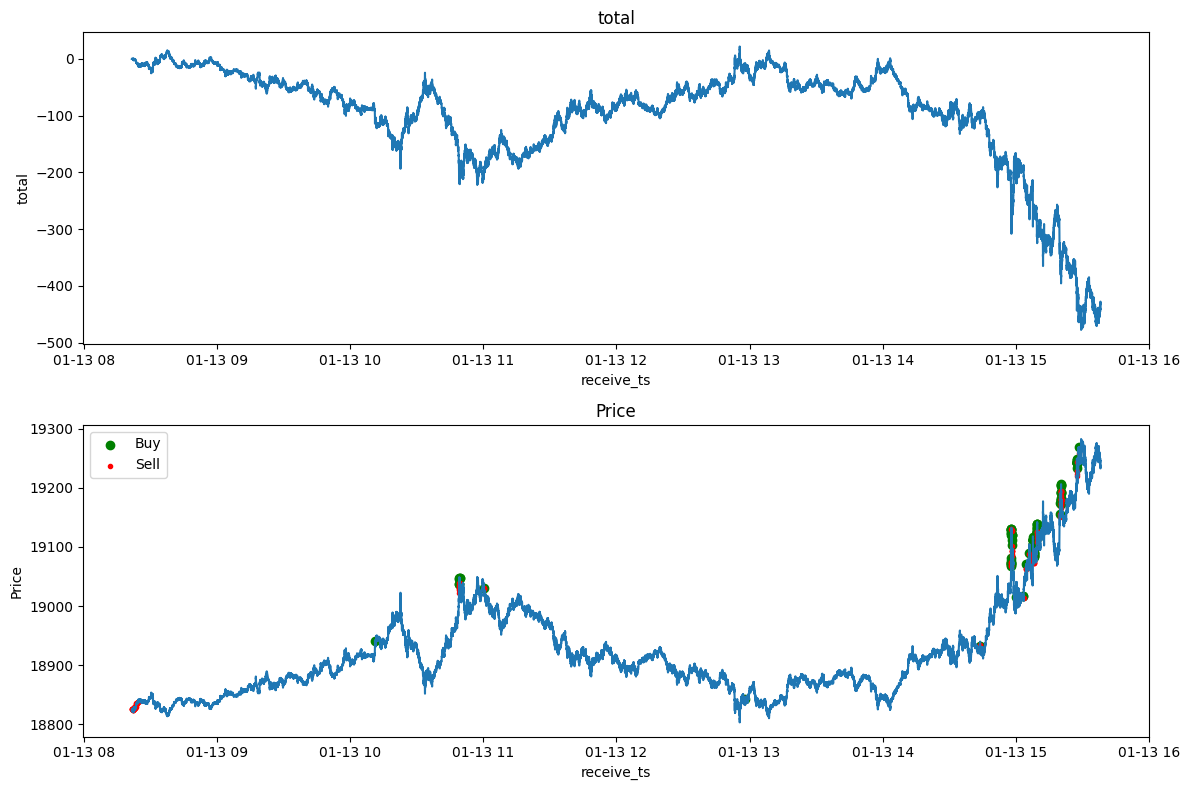

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# 第一个子图: PnL 对时间的变化
ax1.plot(df['receive_ts'], df['total'])
ax1.set_xlabel('receive_ts')
ax1.set_ylabel('total')
ax1.set_title('total')

# 第二个子图: 价格对时间的变化,并标注买入卖出信号
ax2.plot(df['receive_ts'], df['mid_price'])
ax2.scatter(df.loc[df['buy'] == 1, 'receive_ts'], df.loc[df['buy'] == 1, 'mid_price'], color='green', marker='o', label='Buy')
ax2.scatter(df.loc[df['buy'] == -1, 'receive_ts'], df.loc[df['buy'] == -1, 'mid_price'], color='red', marker='.', label='Sell')
ax2.set_xlabel('receive_ts')
ax2.set_ylabel('Price')
ax2.set_title('Price')
ax2.legend()

plt.tight_layout()
plt.show()

In [18]:
actions = {i: 0 for i in range(11)}
for _, _, action_id in actions_history:
    actions[action_id] += 1